# Setup

In [1]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import random
from sklearn.cluster import KMeans
import numpy as np
from dataclasses import dataclass
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from lib.cf_a.cfae import CF_Ascent
from lib.eval.generator import run 
import pandas as pd
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from lib.baycon import execute
from lib.ext.baycon.common.Target import Target

from matplotlib.colors import ListedColormap
from scipy.spatial import distance # For calculating Euclidean distance

import matplotlib.pyplot as plt
import math

%load_ext autoreload
%autoreload 2 

In [37]:
random_state = 5
cf_amount = 100
nc = 2
#X, true_y = load_iris(return_X_y=True)

X, true_y = make_blobs(centers=nc, cluster_std=30, n_features=2, n_samples=32, random_state=random_state)

X = StandardScaler().fit_transform(X)

random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

print(cfs)

[CounterfactualData(cf=[], instance=16, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=1, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=15, target=1, instance_label=np.int32(0)), CounterfactualData(cf=[], instance=10, target=1, instance_label=np.int32(0)), CounterfactualData(cf=[], instance=23, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=15, target=1, instance_label=np.int32(0)), CounterfactualData(cf=[], instance=6, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=0, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=26, target=1, instance_label=np.int32(0)), CounterfactualData(cf=[], instance=11, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=10, target=1, instance_label=np.int32(0)), CounterfactualData(cf=[], instance=8, target=0, instance_label=np.int32(1)), CounterfactualData(cf=[], instance=8, target=0, instance_label=np.i

In [38]:
cfs_final = []
method_name = "cfae" # "cfae" or "dice_mod"

match method_name:
    case "cfae":
        amount = 10
        print('starting cfae')
        for cf in cfs:
            temp_cfs = []
            for i in range(amount):
                print('it: ' + str(i))
                x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance,stop_count=80, center_mode=False) #correction missis = 1, limit = 5
                temp_cfs.append(cf2)
            cfs_final.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))
    case "dice_mod":
        for cf in cfs:
            instance = X[cf.instance].reshape(1, -1)
            gainer = Gainer(centers, X, cf.target, instance, eps=0)
            dice_cf = np.array([
                # random_opt(instance, gainer.gain)[0][0] 
                adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]
            for _ in range(1)])
            cfs_final.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))
    case "necs":
        for cf in cfs:
            i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=cf_amount)
            cfs_final.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))
    case "baycon":
        baycon_cfs = []
        modes = ['kmeans', 'model_agnostic']
        run_mode = modes[1]

        pred = km.predict(X)
        pred = [str(l) for l in pred]
        stacked = np.column_stack((X, pred))
        df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
        df

        baycon_cfs = []
        for cf in cfs:
            point_idx = cf.instance
            point_pred = int(km.predict([X[point_idx]])[0])
            if run_mode == modes[0]:
                t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
            elif run_mode == modes[1]:
                t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

            baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
            cfs_final.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

starting cfae
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it: 4
it: 5
it: 6
it: 7
it: 8
it: 9
it: 0
it: 1
it: 2
it: 3
it

# Correction Test
to see whether cluser changes make counterfactuals correct

In [6]:
from lib.eval.eval_metrics import cf_validity, cf_counterfactual_invalidation

inval = True
average_validity_before = 0.0
average_validity_after = 0.0
kmeans_list = []
fails = []
for i,cf_final in enumerate(cfs_final):

    val_before_array = cf_validity(np.array(cf_final.cf),cf_final.target, centers)
    val_before = float(np.sum(val_before_array))/float(len(val_before_array))
    average_validity_before += val_before

    result, kmeans_new, indicies = cf_counterfactual_invalidation(cf=np.array(cf_final.cf), X=X, instance=cf_final.instance, centers=centers, target=cf_final.target, random_state=42, return_kmeans=True, correction=inval)
    #val = np.sum(result) / float(len(result))
    #average_validity_after += val
    if result is not None:
        for z in range(len(result)):
            if val_before_array[indicies[z]] != result[z]:
                fails.append((i, indicies[z]))

    kmeans_list.append(kmeans_new)

#print("Validty before change: ",average_validity_before / float(len(cfs_final)))
#print("Validty after change: ",average_validity_after / float(len(cfs_final)))

instance: [ 1.51036862 -0.23860524], target: 0, cf: [ 0.80756532 -0.23860524], source: 1
old centers: [[-0.33111841 -0.62569879]
 [ 0.4839423   0.91448285]]
new centers: [[-0.27418423 -0.60634411]
 [ 0.39840677  1.01057352]]
Distance to old centers:
1.2026811950720397
1.1976410150715582
Distance to new centers:
1.142547135318438
1.3144802394480208

In [7]:
palette = plt.get_cmap('Accent', nc)

seen_instances = []

seleccted_fails = []
seleccted_fails.append(fails[0])

# Calculate total number of plots (1 for the 'before CF' + 1 for each unique instance)
unique_instances = []
for fail in seleccted_fails:
    i = fail[0]
    if cfs_final[i].instance not in unique_instances:
        unique_instances.append(cfs_final[i].instance)

total_plots = 1 + len(unique_instances)  # 1 for 'before CF'

cols = 3  # Customize as needed
rows = math.ceil(total_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# 1. Create a meshgrid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# If you don't have data points, you can set fixed limits:
# x_min, x_max = 0, 10
# y_min, y_max = 0, 10

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), # Use a finer step for smoother boundaries
                     np.arange(y_min, y_max, 0.05))

# 4. For each point in the meshgrid, determine which cluster center it is closest to
# Flatten the meshgrid points
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate distances from each grid point to all cluster centers
# Method 1: Using scipy.spatial.distance.cdist (more efficient for large grids)
distances_to_centers = distance.cdist(grid_points, km.cluster_centers_, 'euclidean')
# Assign each grid point to the cluster with the minimum distance
Z = np.argmin(distances_to_centers, axis=1)

# Reshape Z back to the meshgrid shape
Z = Z.reshape(xx.shape)

# 5. Define custom colormaps
cmap_light = ListedColormap(['#FFDDCC', '#DDEEFF', '#CCFFDD']) # Light colors for regions
cmap_bold = ListedColormap(['#FF4500', '#1E90FF', '#32CD32'])

axes[0].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

# --- First plot: Clustering before CF ---
some_kmeans = kmeans_list[0][0]
y_plot = some_kmeans.predict(X)

axes[0].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap_bold, edgecolor='k', alpha=0.8)

fail = seleccted_fails[0]
cf = cfs_final[fail[0]].cf[fail[1]]
instance = X[cfs_final[fail[0]].instance]
axes[0].scatter(instance[0], instance[1], s=50, alpha=0.75, label='x', c="purple", edgecolor='black', linewidth=1)
# Counterfactual with border
axes[0].scatter(cf[0], cf[1], c="blue", s=50, alpha=0.75, label="x'", edgecolor='black', linewidth=1)
axes[0].annotate('', xy=cf, xytext=instance,
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

axes[0].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=50, alpha=0.75, c="cyan", edgecolor='black', linewidth=1)
axes[0].set_title("Invalid CF")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

plot_idx = 1  # Start filling from the second subplot

# --- Remaining plots: Clustering after CF ---
for fail in seleccted_fails:
    i = fail[0]
    z = fail[1]
    some_kmeans = kmeans_list[i][z]
    y_plot = some_kmeans.predict(X)
    instance = X[cfs_final[i].instance]
    target = cfs_final[i].target
    cf = cfs_final[i].cf[z]

    if cfs_final[i].instance in seen_instances:
        continue
    seen_instances.append(cfs_final[i].instance)

    ax = axes[plot_idx]
    plot_idx += 1

    # 1. Create a meshgrid for plotting decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # If you don't have data points, you can set fixed limits:
    # x_min, x_max = 0, 10
    # y_min, y_max = 0, 10

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), # Use a finer step for smoother boundaries
                        np.arange(y_min, y_max, 0.05))

    # 4. For each point in the meshgrid, determine which cluster center it is closest to
    # Flatten the meshgrid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Calculate distances from each grid point to all cluster centers
    # Method 1: Using scipy.spatial.distance.cdist (more efficient for large grids)
    distances_to_centers = distance.cdist(grid_points, some_kmeans.cluster_centers_, 'euclidean')
    # Assign each grid point to the cluster with the minimum distance
    Z = np.argmin(distances_to_centers, axis=1)

    # Reshape Z back to the meshgrid shape
    Z = Z.reshape(xx.shape)

    # 5. Define custom colormaps
    cmap_light = ListedColormap(['#FFDDCC', '#DDEEFF', '#CCFFDD']) # Light colors for regions
    cmap_bold = ListedColormap(['#FF4500', '#1E90FF', '#32CD32'])

    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    

    ax.scatter(X[:, 0], X[:, 1], c=y_plot, s=30, cmap=cmap_bold, edgecolor='k', alpha=0.8)
    
    # Instance (original point) with border
    ax.scatter(instance[0], instance[1], s=50, alpha=0.75, label='x', c="purple", edgecolor='black', linewidth=1)
    # Counterfactual with border
    ax.scatter(cf[0], cf[1], c="blue", s=50, alpha=0.75, label="x'", edgecolor='black', linewidth=1)
    
    
    ax.annotate('', xy=cf, xytext=instance,
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
               c="cyan", s=50, alpha=0.75, label='Original centers', edgecolor='black', linewidth=1)
    ax.scatter(some_kmeans.cluster_centers_[:, 0], some_kmeans.cluster_centers_[:, 1],
               c="orange", s=50, alpha=0.75, label='Updated centers', edgecolor='black', linewidth=1)
    ax.set_title(f"Corrected CF due to cluster change")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

    print(f"instance: {instance}, target: {cfs_final[i].target}, cf: {cf}, source: {cfs_final[i].instance_label}")
    print(f"old centers: {km.cluster_centers_}")
    print(f"new centers: {some_kmeans.cluster_centers_}")

    print("Distance to old centers:")
    print(np.linalg.norm(km.cluster_centers_[0] - cf))
    print(np.linalg.norm(km.cluster_centers_[1] - cf))
    print("Distance to new centers:")
    print(np.linalg.norm(some_kmeans.cluster_centers_[0] - cf))
    print(np.linalg.norm(some_kmeans.cluster_centers_[1] - cf))

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

# Optional: show legend in first or a custom location
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',bbox_to_anchor=(0.05,0.93))

plt.tight_layout()
plt.show()


IndexError: list index out of range

# Invalidation Test
to see whether cluser changes make counterfactuals correct

In [41]:
from lib.eval.eval_metrics import cf_validity, cf_counterfactual_invalidation

average_validity_before = 0.0
average_validity_after = 0.0
kmeans_list = []
fails = []
for i,cf_final in enumerate(cfs_final):

    val_before_array = cf_validity(np.array(cf_final.cf),cf_final.target, centers)
    val_before = float(np.sum(val_before_array))/float(len(val_before_array))
    average_validity_before += val_before

    result, kmeans_new, indicies = cf_counterfactual_invalidation(cf=np.array(cf_final.cf), X=X, instance=cf_final.instance, centers=centers, target=cf_final.target, random_state=42, return_kmeans=True)
    val = np.sum(result) / float(len(result))
    average_validity_after += val


    for z,ind in enumerate(indicies):
        if val_before_array[ind] != result[z]:
            fails.append((i, z))

    kmeans_list.append(kmeans_new)

print("Validty before change: ",average_validity_before / float(len(cfs_final)))
print("Validty after change: ",average_validity_after / float(len(cfs_final)))



Validty before change:  0.9980000000000001
Validty after change:  0.030000000000000006


instance: [-0.07364819  1.54558723], target: 0, cf: [-0.2392858  0.2298578], source: 1
old centers: [[-0.54886421 -0.67521648]
 [ 0.6220461   0.76524534]]
new centers: [[-0.53166541 -0.62493457]
 [ 0.67173855  0.70950664]]
Distance to old centers:
0.9565554002133585
1.0141658979551404
Distance to new centers:
0.9034134335348385
1.0295767953096568
0
instance: [0.13984783 0.11509754], target: 0, cf: [ 0.13984783 -0.04118791], source: 1
old centers: [[-0.54886421 -0.67521648]
 [ 0.6220461   0.76524534]]
new centers: [[-0.51060243 -0.63999267]
 [ 0.65648884  0.81168447]]
Distance to old centers:
0.9361177828521793
0.9396008520104371
Distance to new centers:
0.8841112393603915
0.9971505519452593
1
instance: [-0.35752315 -0.4258047 ], target: 1, cf: [-0.01650522  0.12101955], source: 0
old centers: [[-0.54886421 -0.67521648]
 [ 0.6220461   0.76524534]]
new centers: [[-0.61195179 -0.81524354]
 [ 0.49490794  0.66445744]]
Distance to old centers:
0.9578089111223095
0.9070692694799494
Distance t

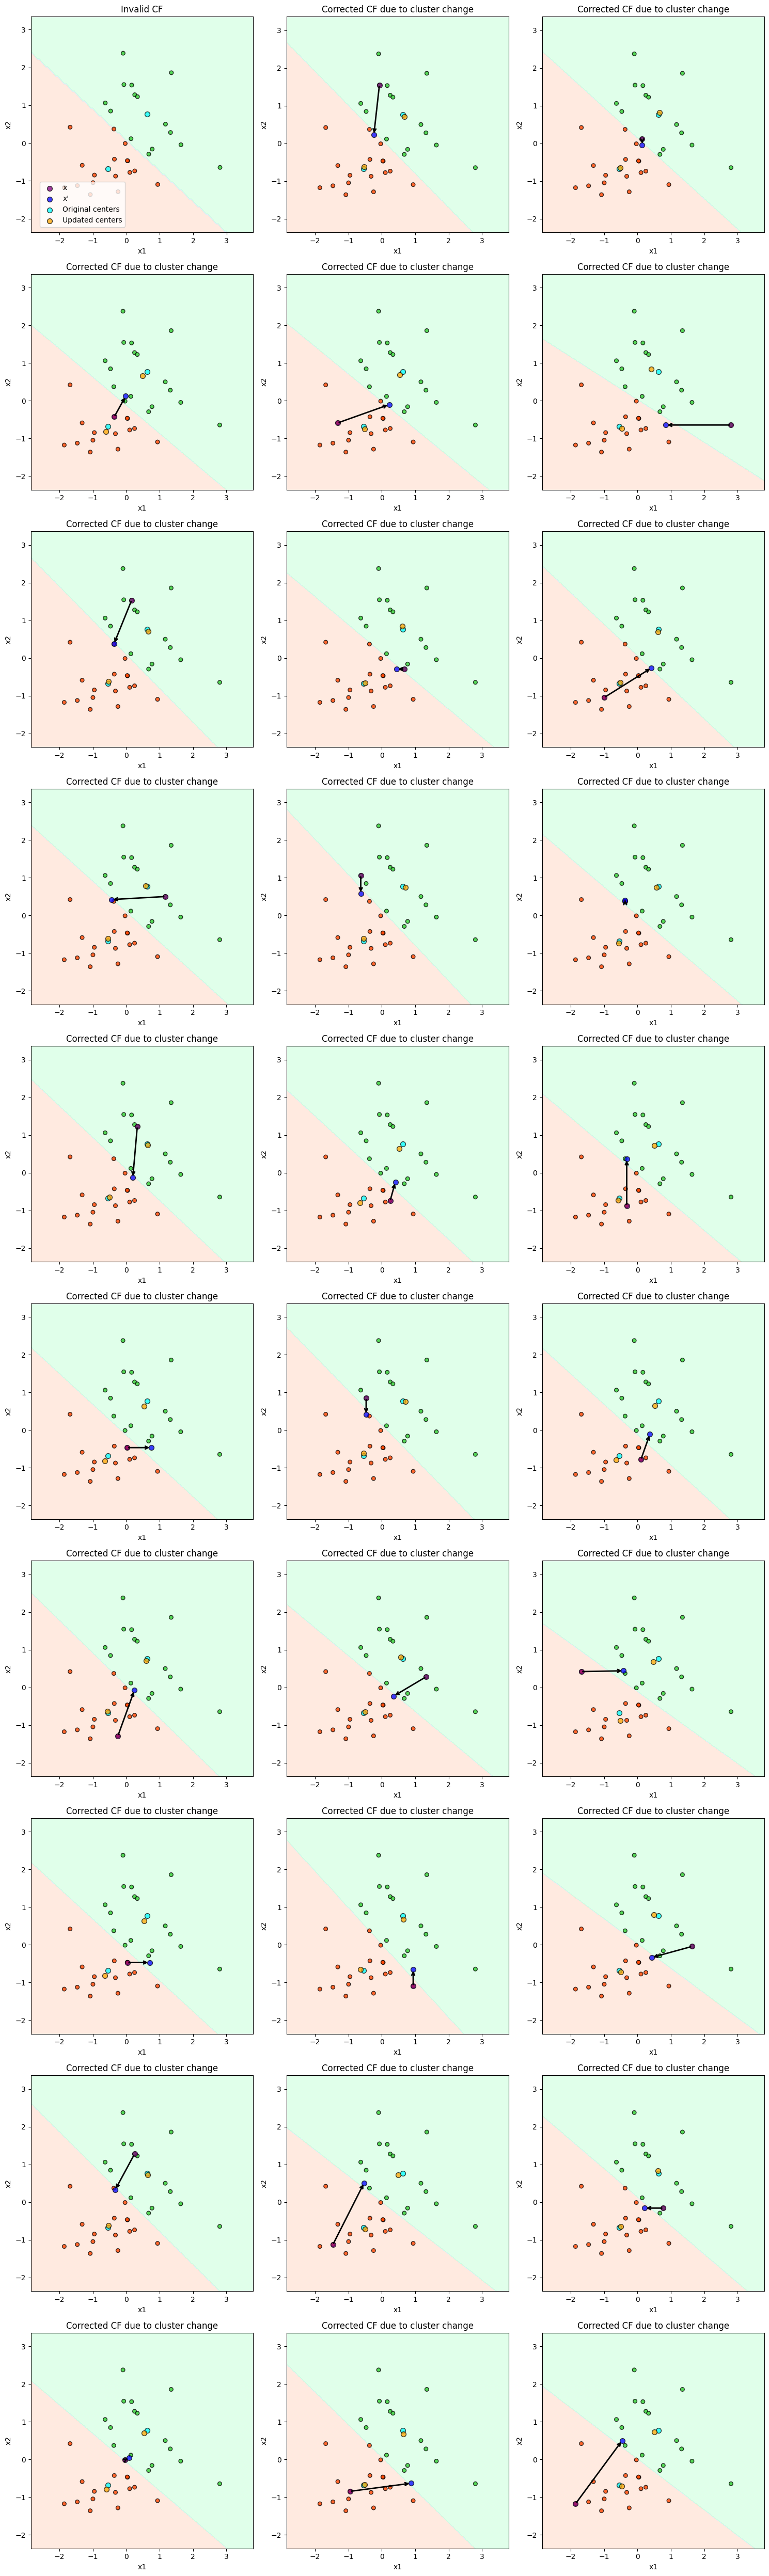

In [ ]:
palette = plt.get_cmap('Accent', nc)

seen_instances = []

seleccted_fails = []
#seleccted_fails.append(fails[4])

# Calculate total number of plots (1 for the 'before CF' + 1 for each unique instance)
unique_instances = []
for fail in fails:#seleccted_fails:
    i = fail[0]
    if cfs_final[i].instance not in unique_instances:
        unique_instances.append(cfs_final[i].instance)
        seleccted_fails.append(fail)

total_plots = 1 + len(unique_instances)  # 1 for 'before CF'

cols = 3  # Customize as needed
rows = math.ceil(total_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# 1. Create a meshgrid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# If you don't have data points, you can set fixed limits:
# x_min, x_max = 0, 10
# y_min, y_max = 0, 10

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), # Use a finer step for smoother boundaries
                     np.arange(y_min, y_max, 0.05))

# 4. For each point in the meshgrid, determine which cluster center it is closest to
# Flatten the meshgrid points
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate distances from each grid point to all cluster centers
# Method 1: Using scipy.spatial.distance.cdist (more efficient for large grids)
distances_to_centers = distance.cdist(grid_points, km.cluster_centers_, 'euclidean')
# Assign each grid point to the cluster with the minimum distance
Z = np.argmin(distances_to_centers, axis=1)

# Reshape Z back to the meshgrid shape
Z = Z.reshape(xx.shape)

# 5. Define custom colormaps
cmap_light = ListedColormap(['#FFDDCC', '#DDEEFF', '#CCFFDD']) # Light colors for regions
cmap_bold = ListedColormap(['#FF4500', '#1E90FF', '#32CD32'])

axes[0].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

# --- First plot: Clustering before CF ---
some_kmeans = km
y_plot = some_kmeans.predict(X)

axes[0].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap_bold, edgecolor='k', alpha=0.8)
# Counterfactual with border

#fail = seleccted_fails[0]
#cf = cfs_final[fail[0]].cf[fail[1]]
#instance = X[cfs_final[fail[0]].instance]
#axes[0].scatter(instance[0], instance[1], s=50, alpha=0.75, label='x', c="purple", edgecolor='black', linewidth=1)
# Counterfactual with border
#axes[0].scatter(cf[0], cf[1], c="blue", s=50, alpha=0.75, label="x'", edgecolor='black', linewidth=1)
#axes[0].annotate('', xy=cf, xytext=instance,
#                arrowprops=dict(arrowstyle='->', color='black', lw=2))

axes[0].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=50, alpha=0.75, c="cyan", edgecolor='black', linewidth=1)
axes[0].set_title("Invalid CF")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

plot_idx = 1  # Start filling from the second subplot

# --- Remaining plots: Clustering after CF ---
for fail in seleccted_fails:
    i = fail[0]
    z = fail[1]
    some_kmeans = kmeans_list[i][z]
    y_plot = some_kmeans.predict(X)
    instance = X[cfs_final[i].instance]
    target = cfs_final[i].target
    cf = cfs_final[i].cf[z]

    print(f"instance: {instance}, target: {cfs_final[i].target}, cf: {cf}, source: {cfs_final[i].instance_label}")
    print(f"old centers: {km.cluster_centers_}")
    print(f"new centers: {some_kmeans.cluster_centers_}")

    print("Distance to old centers:")
    print(np.linalg.norm(km.cluster_centers_[0] - cf))
    print(np.linalg.norm(km.cluster_centers_[1] - cf))
    print("Distance to new centers:")
    print(np.linalg.norm(some_kmeans.cluster_centers_[0] - cf))
    print(np.linalg.norm(some_kmeans.cluster_centers_[1] - cf))
    print(i)

    if cfs_final[i].instance in seen_instances:
        continue
    seen_instances.append(cfs_final[i].instance)

    ax = axes[plot_idx]
    plot_idx += 1

    # 1. Create a meshgrid for plotting decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # If you don't have data points, you can set fixed limits:
    # x_min, x_max = 0, 10
    # y_min, y_max = 0, 10

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), # Use a finer step for smoother boundaries
                        np.arange(y_min, y_max, 0.02))

    # 4. For each point in the meshgrid, determine which cluster center it is closest to
    # Flatten the meshgrid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Calculate distances from each grid point to all cluster centers
    # Method 1: Using scipy.spatial.distance.cdist (more efficient for large grids)
    distances_to_centers = distance.cdist(grid_points, some_kmeans.cluster_centers_, 'euclidean')
    # Assign each grid point to the cluster with the minimum distance
    Z = np.argmin(distances_to_centers, axis=1)

    # Reshape Z back to the meshgrid shape
    Z = Z.reshape(xx.shape)

    # 5. Define custom colormaps
    cmap_light = ListedColormap(['#FFDDCC', '#DDEEFF', '#CCFFDD']) # Light colors for regions
    cmap_bold = ListedColormap(['#FF4500', '#1E90FF', '#32CD32'])

    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    

    ax.scatter(X[:, 0], X[:, 1], c=y_plot, s=30, cmap=cmap_bold, edgecolor='k', alpha=0.8)
    
    # Instance (original point) with border
    ax.scatter(instance[0], instance[1], s=50, alpha=0.75, label='x', c="purple", edgecolor='black', linewidth=1)
    # Counterfactual with border
    ax.scatter(cf[0], cf[1], c="blue", s=50, alpha=0.75, label="x'", edgecolor='black', linewidth=1)
    
    
    ax.annotate('', xy=cf, xytext=instance,
                arrowprops=dict(arrowstyle='->', color='black', lw=2))
    ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
               c="cyan", s=50, alpha=0.75, label='Original centers', edgecolor='black', linewidth=1)
    ax.scatter(some_kmeans.cluster_centers_[:, 0], some_kmeans.cluster_centers_[:, 1],
               c="orange", s=50, alpha=0.75, label='Updated centers', edgecolor='black', linewidth=1)
    ax.set_title(f"Corrected CF due to cluster change")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

# Optional: show legend in first or a custom location
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',bbox_to_anchor=(0.05,0.93))

plt.tight_layout()
plt.show()